In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification
from transformers import pipeline
from nn_functions.nn_functions import get_signals, get_sentiment_score
from data.train_test_data import get_train_test_data

/opt/anaconda3/envs/mfe_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading 

Approximately 17s (text, no sentiment score)

Load data for first time

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_data()
# X_train.to_csv("X_train.csv") 
# X_test.to_csv("X_test.csv")
# y_train.to_csv("y_train.csv")
# y_test.to_csv("y_test.csv")

/Users/kilianwan/Desktop/EPFL/Master/FE - MA2/Machine Learning for Finance/Project/lesfousdubitume/data/load_data.py:27: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
# X_train = pd.read_csv("X_train.csv") 
# X_test = pd.read_csv("X_test.csv")
# y_train = pd.read_csv("y_train.csv")
# y_test = pd.read_csv("y_test.csv")

In [3]:
# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (61808, 37)
X_test shape: (20039, 37)
y_train shape: (61808, 5)
y_test shape: (20039, 5)


In [ ]:
# Load FinBERT model
print("Loading FinBERT...")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
# Load FinBERT pipeline on correct device
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if device.type == 'mps' else -1)

X_train_sentiment = get_signals(X_train, nlp, threshold=0.3)
X_test_sentiment = get_signals(X_test, nlp, threshold = 0.3)

# One-hot encoder

In [254]:
def quarter_one_hot(quarter_series):
    """
    Given a pd.Series of quarters (1,2,3,4), return an array with one-hot encoding
    """ 
    one_hot = np.zeros((len(quarter_series), 4))
    one_hot[np.arange(len(quarter_series)), quarter_series.values.astype(int) - 1] = 1
    return one_hot
    

# Build rolling window dataset

Here we build the rolling windows datasets to feed the LSTM model

In [312]:
def build_rolling_window_dataset(X_df, y_df, window_size=8, sentiment=False):
    X_sequences = []
    y_targets = []
    meta = []
    used_indices = set()

    pca_columns = [str(i) for i in range(32)]  # PCA 
    for cusip, stock_X in X_df.groupby('cusip'):
        stock_y = y_df[y_df['cusip'] == cusip]

        stock_X_sorted = stock_X.sort_values(['year', 'quarter'])
        stock_y_sorted = stock_y.sort_values(['year', 'quarter'])

        X_pca_vals = stock_X_sorted[pca_columns].values
        quarter_OH = quarter_one_hot(stock_X_sorted['quarter'])
        
        if sentiment:
            sentiment_vals = stock_X_sorted['sentiment_score'].values.reshape(-1, 1)
            X_features = np.concatenate([X_pca_vals, quarter_OH, sentiment_vals], axis=1)
        else: 
            X_features = np.concatenate([X_pca_vals, quarter_OH], axis=1)

        y_values = stock_y_sorted['ret'].values
        year_values = stock_y_sorted['year'].values
        quarter_values = stock_y_sorted['quarter'].values
        gvkey_values = stock_y_sorted['gvkey'].values

        n_samples = len(X_features) - window_size
        if n_samples <= 0:
            continue

        used_indices.update(stock_X_sorted.index.tolist())

        for i in range(n_samples):
            X_seq = X_features[i:i + window_size]
            y_target = y_values[i + window_size]

            # Save for plots after:
            meta.append({
                'cusip': cusip,
                'year': year_values[i + window_size],
                'quarter': quarter_values[i + window_size],
                'gvkey': gvkey_values[i + window_size],
            })

            X_sequences.append(X_seq)
            y_targets.append(y_target)

    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    meta_df = pd.DataFrame(meta)
    used_indices = list(used_indices)

    print(f"Built rolling window dataset: {len(X_sequences)} samples ")

    return X_sequences, y_targets, meta_df, used_indices

In [313]:
# empirically, we have seen that the samples for the LSTM sentiment model has a smaller number of indices
rows_to_match = X_train_sentiment[['cusip', 'year', 'quarter', 'gvkey']].drop_duplicates()

X_train = X_train.merge(rows_to_match, on=['cusip', 'year', 'quarter', 'gvkey'], how='inner')
y_train = y_train.merge(rows_to_match, on=['cusip', 'year', 'quarter', 'gvkey'], how='inner')

In [314]:
# Train rolling window for baseline
X_train_lstm, y_train_lstm, meta_train, train_used_indices = build_rolling_window_dataset(X_train, y_train, sentiment=False)

# Test rolling window for baseline
X_test_lstm, y_test_lstm, _, _ = build_rolling_window_dataset(X_test, y_test, sentiment=False)

# Save indices:
#pd.Series(train_used_indices).to_csv("X_train_lstm_indices.csv")

Built rolling window dataset: 32507 samples 
Built rolling window dataset: 1776 samples 


In [ ]:
# Train rolling window for sentiment
X_train_sentiment_lstm, y_train_sentiment_lstm, _, _ = build_rolling_window_dataset(X_train_sentiment, y_train, sentiment=True)

X_test_sentiment_lstm, y_test_sentiment_lstm, _, _ = build_rolling_window_dataset(X_test_sentiment, y_test, sentiment=True)

Built rolling window dataset: 32507 samples 
Built rolling window dataset: 1776 samples 


# **LSTM definition**

In [327]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMRegressor, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Final linear layer
        self.fl = nn.Linear(hidden_dim, 1) # map the hidden state to the predicted return
        
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1] # shape : (batch_size, hidden_dim)
        output = self.fl(last_hidden) # shape : (batch_size, 1), so predicted return
        return output.squeeze(-1) # shape (batch_size,)

# **Initializing the models**

## **1. Baseline model**

In [347]:
input_dim = X_train_lstm.shape[2] # so number of features : 36
hidden_dim = 64 # maybe change it
num_layers = 2 
learning_rate = 1e-3

model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers
)

optimizer_baseline = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion_baseline = nn.MSELoss()

# prepare data for pytorch, loader etc
X_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)

train_dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 64
train_loader_baseline = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # since we assume no temporal correlation, shuffle = True

## **2. Sentiment model**

In [348]:
input_dim = X_train_sentiment_lstm.shape[2] # so number of features : 37 (since we have + sentiment)
hidden_dim = 64 # maybe change it
num_layers = 2 
learning_rate = 1e-3

model_sentiment = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers
)

optimizer_sentiment = torch.optim.Adam(model_sentiment.parameters(), lr=learning_rate)
criterion_sentiment = nn.MSELoss()

# prepare data for pytorch, loader etc
X_tensor = torch.tensor(X_train_sentiment_lstm, dtype=torch.float32)
y_tensor = torch.tensor(y_train_sentiment_lstm, dtype=torch.float32)

train_dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 64
train_loader_sentiment = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # since we assume no temporal correlation, shuffle = True

# **Training the models**

In [349]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)
model_sentiment = model_sentiment.to(device)

Using device: mps


## **1. Training baseline**

In [350]:
n_epoch = 50

for epoch in range(n_epoch):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader_baseline:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        y_pred = model(batch_X)
        optimizer_baseline.zero_grad()
        loss = criterion_baseline(y_pred, batch_y)
        loss.backward()
        optimizer_baseline.step()
        
        running_loss += loss.item() * batch_X.size(0)
    epoch_loss = running_loss / len(train_loader_baseline.dataset)
    if (epoch % 5 == 0):
        print(f"Epoch {epoch} | Loss : {epoch_loss:.4f}")
        
print(f"Epoch {n_epoch} | Final Loss : {epoch_loss:.4f}")

Epoch 0 | Loss : 0.0354
Epoch 5 | Loss : 0.0323
Epoch 10 | Loss : 0.0294
Epoch 15 | Loss : 0.0268
Epoch 20 | Loss : 0.0246
Epoch 25 | Loss : 0.0225
Epoch 30 | Loss : 0.0206
Epoch 35 | Loss : 0.0189
Epoch 40 | Loss : 0.0172
Epoch 45 | Loss : 0.0159
Epoch 50 | Final Loss : 0.0147


## **2. Training the sentiment model**

In [351]:
n_epoch = 50

for epoch in range(n_epoch):
    model_sentiment.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader_sentiment:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        y_pred = model_sentiment(batch_X)
        optimizer_sentiment.zero_grad()
        loss = criterion_sentiment(y_pred, batch_y)
        loss.backward()
        optimizer_sentiment.step()
        
        running_loss += loss.item() * batch_X.size(0)
    epoch_loss_sentiment = running_loss / len(train_loader_sentiment.dataset)
    if (epoch % 5 == 0):
        print(f"Epoch {epoch} | Loss : {epoch_loss_sentiment:.4f}")
        
print(f"Epoch {n_epoch} | Final Loss (Sentiment): {epoch_loss_sentiment:.4f}")

Epoch 0 | Loss : 0.0352
Epoch 5 | Loss : 0.0316
Epoch 10 | Loss : 0.0288
Epoch 15 | Loss : 0.0264
Epoch 20 | Loss : 0.0242
Epoch 25 | Loss : 0.0221
Epoch 30 | Loss : 0.0202
Epoch 35 | Loss : 0.0183
Epoch 40 | Loss : 0.0164
Epoch 45 | Loss : 0.0146
Epoch 50 | Final Loss (Sentiment): 0.0132


# **Testing the model** 

## **1. Testing baseline**

In [352]:
test_loader_baseline = DataLoader(TensorDataset(torch.tensor(X_test_lstm, dtype=torch.float32), 
                                       torch.tensor(y_test_lstm, dtype=torch.float32)), 
                         batch_size=64, 
                         shuffle=False)  # Important! NO shuffle in test

In [353]:
model.eval()

test_loss_baseline = 0.0

with torch.no_grad():  # Disable gradients for faster computation
    for batch_X, batch_y in test_loader_baseline:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_X)

        loss = criterion_baseline(y_pred, batch_y)

        test_loss_baseline += loss.item() * batch_X.size(0)

test_loss_baseline /= len(test_loader_baseline.dataset)
print(f"Test Loss Baseline: {test_loss_baseline:.4f}")

# test loss with w=8 : 0.0847

Test Loss Baseline: 0.0843


In [354]:
test_loader_sentiment = DataLoader(TensorDataset(torch.tensor(X_test_sentiment_lstm, dtype=torch.float32), 
                                       torch.tensor(y_test_sentiment_lstm, dtype=torch.float32)), 
                         batch_size=64, 
                         shuffle=False)  # Important! NO shuffle in test

In [355]:
model_sentiment.eval()

test_loss_sentiment = 0.0

with torch.no_grad():  # Disable gradients for faster computation
    for batch_X, batch_y in test_loader_sentiment:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        y_pred = model_sentiment(batch_X)

        loss = criterion_sentiment(y_pred, batch_y)

        test_loss_sentiment += loss.item() * batch_X.size(0)

test_loss_sentiment /= len(test_loader_sentiment.dataset)
print(f"Test Loss Sentiment: {test_loss_sentiment:.4f}")

Test Loss Sentiment: 0.0790


# Metrics & Plots

In [356]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_X)

            all_preds.extend(y_pred.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_true = np.array(all_true)
    return all_preds, all_true

In [357]:
all_preds_baseline, all_true_baseline = evaluate_model(model, test_loader_baseline, device)

In [362]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

residuals_baseline = all_true_baseline - all_preds_baseline

mse = mean_squared_error(all_true_baseline, all_preds_baseline)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_true_baseline, all_preds_baseline)
sign_accuracy = (np.sign(all_preds_baseline) == np.sign(all_true_baseline)).mean()

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Directional Accuracy: {sign_accuracy*100:.2f}%")

Mean Squared Error (MSE): 0.0843
Root Mean Squared Error (RMSE): 0.2903
Mean Absolute Error (MAE): 0.2112
Directional Accuracy: 57.49%


In [363]:
all_preds_sentiment, all_true_sentiment = evaluate_model(model_sentiment, test_loader_sentiment, device)

In [364]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

residuals_sentiment = all_true_sentiment - all_preds_sentiment

mse = mean_squared_error(all_true_sentiment, all_preds_sentiment)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_true_sentiment, all_preds_sentiment)
sign_accuracy = (np.sign(all_preds_sentiment) == np.sign(all_true_sentiment)).mean()

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Directional Accuracy: {sign_accuracy*100:.2f}%")

Mean Squared Error (MSE): 0.0790
Root Mean Squared Error (RMSE): 0.2811
Mean Absolute Error (MAE): 0.2036
Directional Accuracy: 57.49%


# **Plots**

## **1. Plots for baseline model**

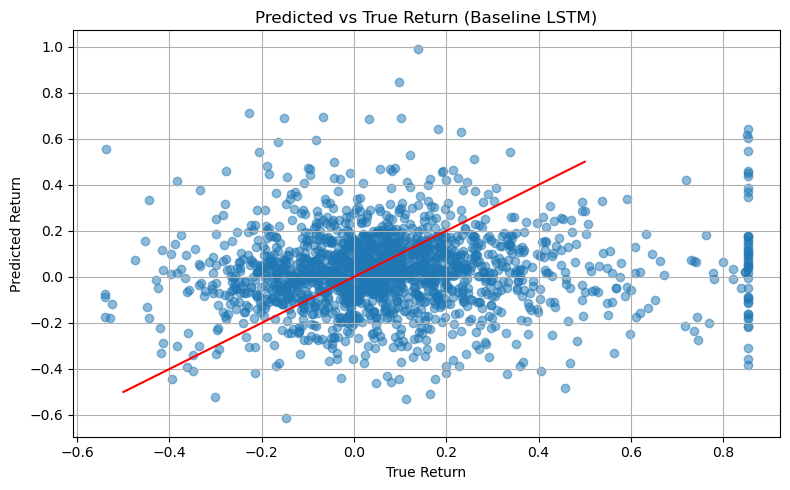

In [376]:
# scatterplot : predicted vs true
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(all_true_baseline, all_preds_baseline, alpha=0.5)
plt.plot([-0.5, 0.5], [-0.5, 0.5], color='red')
plt.title("Predicted vs True Return (Baseline LSTM)")
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/baseline_scatterplot.png")
plt.show()

/opt/anaconda3/envs/mfe_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


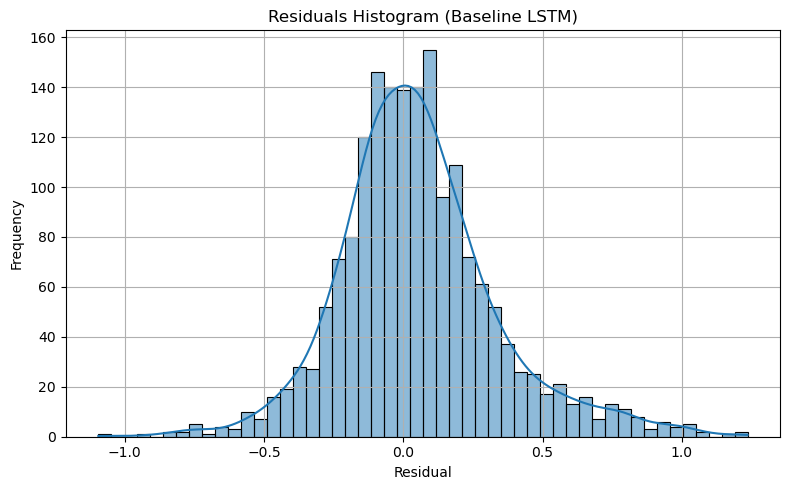

In [375]:
# residuals histogram: 
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(residuals_baseline, kde=True, bins=50)
plt.title("Residuals Histogram (Baseline LSTM)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/baseline_residuals_hist.png")
plt.show()

## **2. Plots for sentiment model**

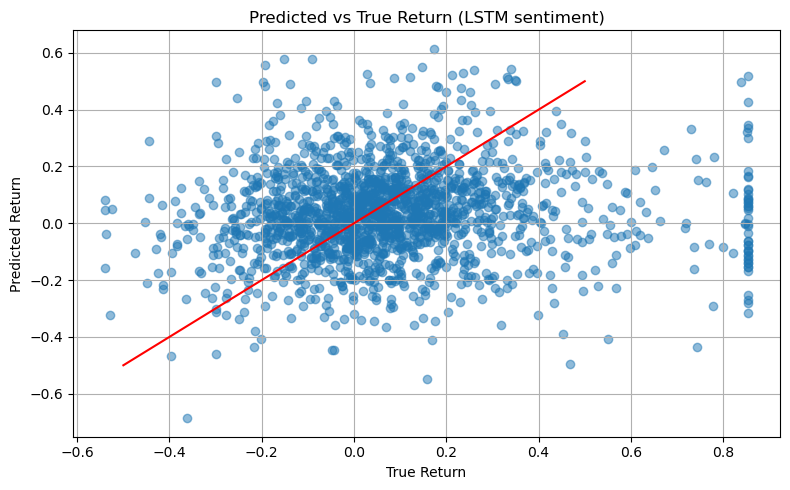

In [374]:
plt.figure(figsize=(8,5))
plt.scatter(all_true_sentiment, all_preds_sentiment, alpha=0.5)
plt.plot([-0.5, 0.5], [-0.5, 0.5], color='red')
plt.title("Predicted vs True Return (LSTM sentiment)")
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/sentiment_scatterplot.png")
plt.show()

/opt/anaconda3/envs/mfe_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


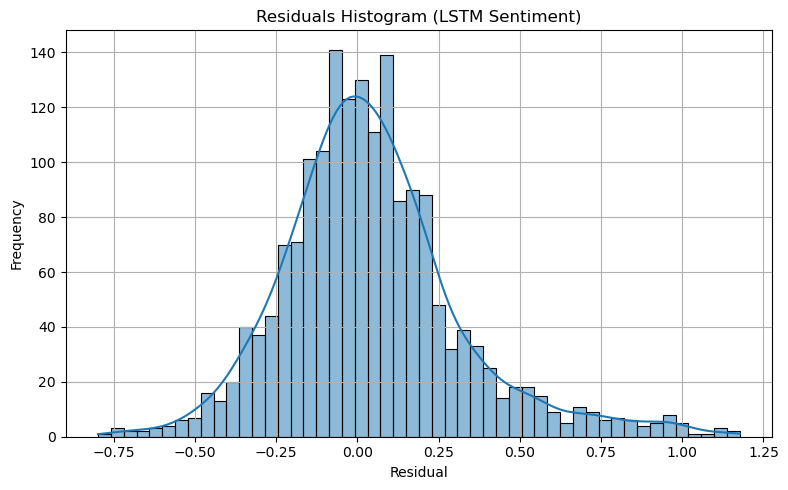

In [369]:
# residuals histogram: 
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(residuals_sentiment, kde=True, bins=50)
plt.title("Residuals Histogram (LSTM Sentiment)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/sentiment_residuals_hist.png")
plt.show()

---


---